In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
from pathlib import Path


# Directories
SPINE = Path.cwd().parents[2]
DATA_DIR = SPINE / "data"
UTL_DIR = DATA_DIR / "utils"

In [2]:
def get_sc_enigma():
    """
    This function loads and transforms the structural connectivity matrix downloaded from the ENIGMA-TOOLBOX
    (which is in the Schaefer200 7-Network atlas into the Schaefer 17-network atlas.

    Args:
        None

    Returns:
        sc_17(np.array): the ENIGMA struc. conn. matrix ordered as the Schaefer200 parcels 17-network atlas
    """
    net17 = pd.read_csv(UTL_DIR / "200Schaefer17Net.txt", delimiter=",")
    net7 = pd.read_csv(UTL_DIR / "200Schaefer7Net.txt", delimiter=",")
    sc = np.loadtxt(UTL_DIR / "sc_enigma_200.csv", delimiter=",")
    net7 = net7.rename(columns={"ROI Label": "ROI_label_7"})
    net17 = net17.rename(columns={"ROI Label": "ROI_label_17"})
    unite_df = pd.merge(net17, net7, on=["R", "A", "S"])
    unite_df.sort_values("ROI_label_7")
    unite_df["ROI_index_17"] = unite_df["ROI_label_17"] - 1
    unite_df["ROI_index_7"] = unite_df["ROI_label_7"] - 1
    unite_df = unite_df.sort_values("ROI_label_7")
    seven_to_teen_dict = pd.Series(
        unite_df.ROI_index_17.values, index=unite_df.ROI_index_7
    ).to_dict()
    sc_17 = sc.copy()
    for k, v in seven_to_teen_dict.items():
        sc_17[:, [k, v]] = sc_17[:, [v, k]]
        sc_17[[k, v], :] = sc_17[[v, k], :]
    sc_17[sc_17 < 0] = 0
    # logMatrix = np.log(sc_17+1)
    # maxNodeInput = np.max(np.sum(sc_17, axis=0))  
    # maxLogInput = np.max(np.sum(logMatrix, axis=0))
    # finalMatrix = logMatrix * maxNodeInput / maxLogInput
    return sc_17

In [3]:
G = 0.3
a = -0.02

SC = get_sc_enigma()
SC = SC * 0.2 / SC.max()
omega = np.array([0.3]*200)

SCT = SC.T
ink = SCT.sum(axis = 1)
DM = np.zeros_like(SC)

dt = 10e-5
Tmaxneuronal = 193
doBookkeeping = True
initialValue = 0.001

N = SC.shape[0]
x = initialValue * np.ones(N)  # Initialize x
y = initialValue * np.ones(N)  # Initialize y
simVars =  np.array([x, y])

In [4]:
sigma = 0.2
ds = 1  # downsampling stepsize

np.random.seed(0)

def initBookkeeping(N, tmax):
    # global curr_xn, curr_rn, nn
    # global curr_obsVars
    # curr_xn = np.zeros((int(tmax), N))
    # curr_rn = np.zeros((int(tmax), N))
    obsVars = 2
    timeElements = int(tmax/ds) + 1  # the last +1 because of isClose roundings...
    return np.zeros((timeElements, obsVars, N))

@jit(nopython=True)
def recordBookkeeping(t, obsVars, curr_obsVars):
    # global curr_obsVars
    nn = int(np.round(t/ds))  # is is an int-ish...
    curr_obsVars[nn,:,:] = obsVars[:,:]
    return curr_obsVars

@jit(nopython=True)
def dfun(simVars, p):  # p is the stimulus...?
    x = simVars[0]; y = simVars[1]
    pC = p + 0j
    xcoup = np.dot(SCT,x) - ink * x  # sum(Cij*xi) - sum(Cij)*xj
    ycoup = np.dot(SCT,y) - ink * y  #
    dx = (a - x**2 - y**2) * x - omega * y + G * xcoup + pC.real
    dy = (a - x**2 - y**2) * y + omega * x + G * ycoup + pC.imag
    return np.stack((dx, dy)), np.stack((x, y))

@jit(nopython=True)
def integrationStep(simVars, dt, stimulus):  #, curr_obsVars, doBookkeeping):
    numSimVars = simVars.shape[0]; N = simVars.shape[1]
    dvars_obsVars = dfun(simVars, stimulus)
    dvars = dvars_obsVars[0]; obsVars = dvars_obsVars[1]  # cannot use unpacking in numba...
    simVars = simVars + dt * dvars + np.sqrt(dt) * sigma * np.random.randn(numSimVars,N)  # Euler-Maruyama integration.
    return simVars, obsVars


@jit(nopython=True)
def integrationLoop(dt, Tmaxneuronal, simVars, doBookkeeping, curr_obsVars):
    for t in np.arange(0, Tmaxneuronal, dt):
        stimulus = 0
        simVars_obsVars = integrationStep(simVars, dt, stimulus)
        simVars = simVars_obsVars[0]; obsVars = simVars_obsVars[1]  # cannot use unpacking in numba...
        if doBookkeeping:
            curr_obsVars = recordBookkeeping(t, obsVars, curr_obsVars)
    return simVars, curr_obsVars


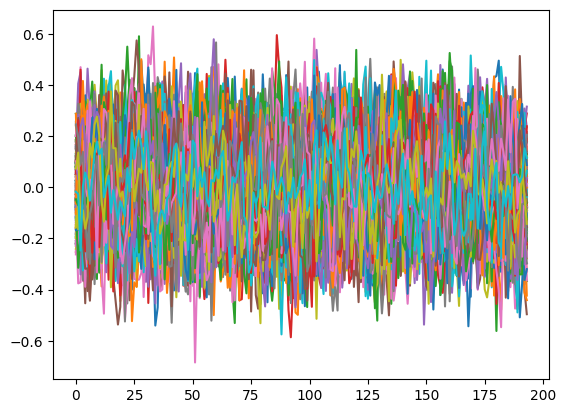

In [5]:
curr_obsVars = initBookkeeping(N, Tmaxneuronal)
simVars, curr_obsVars = integrationLoop(dt, Tmaxneuronal, simVars, doBookkeeping, curr_obsVars)
x = curr_obsVars[:,0,:]
plt.plot(x);
gus_mat = np.corrcoef(x)

In [42]:
x = curr_obsVars[:,0]
x[0] = np.ones(200)
DM = DM.astype(int)
for t in np.arange(x.shape[0]):
    for j in np.arange(x.shape[1]):
        print(x[j, t - DM[1, j] - 1])

1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


IndexError: index 194 is out of bounds for axis 0 with size 194

In [37]:
x

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
ds = 1  # downsampling stepsize
def initSim(N):
    global SCT, ink
    SCT = SC.T
    ink = SCT.sum(axis=1)   # Careful: component 2 in Matlab is component 1 in Python
    x = initialValue * np.ones(N)  # Initialize x
    y = initialValue * np.ones(N)  # Initialize y
    return np.array([x, y])


# Variables of interest, needed for bookkeeping tasks...
# x = y = None
def numObsVars():  # Returns the number of observation vars used, here xn and rn
    return 2

# ----------------- supercritical Hopf bifurcation model ----------------------
@jit(nopython=True)
def dfun(simVars, curr_obsVars, n_step, p):  # p is the stimulus...?
    x = simVars[0]; y = simVars[1]
    N = x.shape[0]
    x_all = curr_obsVars[:,0]
    y_all = curr_obsVars[:,1]
    pC = p + 0j
    x_coup = np.zeros(N)
    y_coup = np.zeros(N)
    for i in range(N):
        x_coup[i] = 0
        y_coup[i] = 0
        for j in range(N):
            x_coup[i] += G * SC[i, j] * (x_all[j, n_step - DM[i, j] - 1] - x_all[i, n_step - 1] )
            y_coup[i] += G * SC[i, j] * (y_all[j, n_step - DM[i, j] - 1]- y_all[i, n_step -1])
    dx = (a - x**2 - y**2) * x - omega * y + x_coup + pC.real
    dy = (a - x**2 - y**2) * y + omega * x + y_coup + pC.imag
    return np.stack((dx, dy)), np.stack((x, y))

def initBookkeeping(N, tmax):
    # global curr_xn, curr_rn, nn
    # global curr_obsVars
    # curr_xn = np.zeros((int(tmax), N))
    # curr_rn = np.zeros((int(tmax), N))
    obsVars = numObsVars()
    timeElements = int(tmax/ds) + 1  # the last +1 because of isClose roundings...
    return np.zeros((timeElements, obsVars, N))


@jit(nopython=True)
def recordBookkeeping(t, obsVars, curr_obsVars):
    # global curr_obsVars
    if np.isint(t/ds):
        nn = int(np.round(t/ds))  # is is an int-ish...
        curr_obsVars[nn,:,:] = obsVars[:,:]
    return curr_obsVars


# ==========================================================================
# ==========================================================================
# ==========================================================================
# Euler-Maruyama Integration
# --------------------------------------------------------------------------
sigma = 0.01
clamping = True
@jit(nopython=True)
def integrationStep(simVars, curr_obsVars, n_step, dt, stimulus):  #, curr_obsVars, doBookkeeping):
    numSimVars = simVars.shape[0]; N = simVars.shape[1]
    dvars_obsVars = dfun(simVars, curr_obsVars, n_step, stimulus)
    dvars = dvars_obsVars[0]; obsVars = dvars_obsVars[1]  # cannot use unpacking in numba...
    simVars = simVars + dt * dvars + np.sqrt(dt) * sigma * randn(numSimVars,N)  # Euler-Maruyama integration.
    if clamping:
        simVars = np.where(simVars > 1., 1., simVars)  # clamp values to 0..1
        simVars = np.where(simVars < 0., 0., simVars)
    return simVars, obsVars


@jit(nopython=True)
def integrationLoop(dt, Tmaxneuronal, simVars, doBookkeeping, curr_obsVars):
    for t in np.arange(0, Tmaxneuronal-1, dt):
        stimulus = 0
        n_step = int(t/dt)
        simVars_obsVars = integrationStep(simVars, curr_obsVars, n_step, dt, stimulus)
        simVars = simVars_obsVars[0]; obsVars = simVars_obsVars[1]  # cannot use unpacking in numba...
        if doBookkeeping:
            curr_obsVars = recordBookkeeping(t, obsVars, curr_obsVars)
    return simVars, curr_obsVars



# # @jit(nopython=True)
def integrate(dt, Tmaxneuronal, simVars, doBookkeeping=True):
    # numSimVars = simVars.shape[0]
    N = simVars.shape[1]  # N = neuronalModel.SC.shape[0]  # size(C,1) #N = CFile["Order"].shape[1]
    curr_obsVars = initBookkeeping(N, Tmaxneuronal)
    simVars, obsVars = integrationLoop(dt, Tmaxneuronal, simVars, doBookkeeping, curr_obsVars)
    return simVars, obsVars # simVars sono x e y allo step prima e obsvars sono dopo integrazione


In [7]:
curr_obsVars = initBookkeeping(N, Tmaxneuronal)
simVars_currObsVars = integrate(dt, Tmaxneuronal, simVars, doBookkeeping=True)
simvars = simVars_currObsVars[0]; curr_obsVars = simVars_currObsVars[1]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Failed in nopython mode pipeline (step: nopython frontend)
NameError: name 'randn' is not defined
During: resolving callee type: type(CPUDispatcher(<function integrationStep at 0x7f6200df3dc0>))
During: typing of call at /tmp/ipykernel_13954/1846090901.py (79)

During: resolving callee type: type(CPUDispatcher(<function integrationStep at 0x7f6200df3dc0>))
During: typing of call at /tmp/ipykernel_13954/1846090901.py (79)


File "../../../../../../tmp/ipykernel_13954/1846090901.py", line 79:
<source missing, REPL/exec in use?>
